In [1]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import pyproj
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# check python version and all packages version
def check_python_version():
    import sys
    print("Python version")
    print (sys.version)
    print("Pandas version")
    print(pd.__version__)
    print("Geopandas version")
    print(gpd.__version__)
    print("Xarray version")
    print(xr.__version__)
    print("Pyproj version")
    print(pyproj.__version__)

check_python_version()

Python version
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version
2.2.2
Geopandas version
0.14.2
Xarray version
2023.6.0
Pyproj version
3.6.1


In [3]:
fire_label = pd.read_parquet('../Clean_Data/Model_Data/fire_label_fod_fpa_2001_2020_downsample.parquet')
fire_label_OOT = pd.read_parquet('../Clean_Data/Model_Data/fire_label_fod_fpa_2020_OOT.parquet')

In [4]:
fire_label.shape, fire_label.dtypes

((7264829, 4),
 lon               float64
 lat               float64
 day        datetime64[ns]
 IS_FIRE             int32
 dtype: object)

In [5]:
fire_label_OOT.shape, fire_label_OOT.dtypes

((5022540, 4),
 lon               float64
 lat               float64
 day        datetime64[ns]
 IS_FIRE             int32
 dtype: object)

In [6]:
fire_label.head()

,lon,lat,day,IS_FIRE
197,-124.391667,40.441667,2001-07-17,1
1727,-124.391667,40.441667,2005-09-24,1
4592,-124.391667,40.441667,2014-07-30,1
10419,-124.391667,40.400000,2007-07-14,1
16506,-124.350000,40.566667,2001-03-14,1


In [7]:
# Force garbage collection
import gc
gc.collect()

0

In [8]:
features = pd.read_parquet('../Clean_Data/Weather_Data_w_Veg_Filter_Fire_12KM_Merged.parquet')

In [10]:
features.dtypes

lon                                                 float64
lat                                                 float64
day                                          datetime64[ns]
dead_fuel_moisture_1000hr                           float32
dead_fuel_moisture_100hr                            float32
pdsi                                                float32
category                                            float32
air_temperature_x                                   float64
relative_humidity_x                                 float32
max_wind_speed                                      float32
air_temperature_y                                   float64
relative_humidity_y                                 float32
precipitation_amount                                float32
specific_humidity                                   float32
surface_downwelling_shortwave_flux_in_air           float32
wind_from_direction                                 float32
wind_speed                              

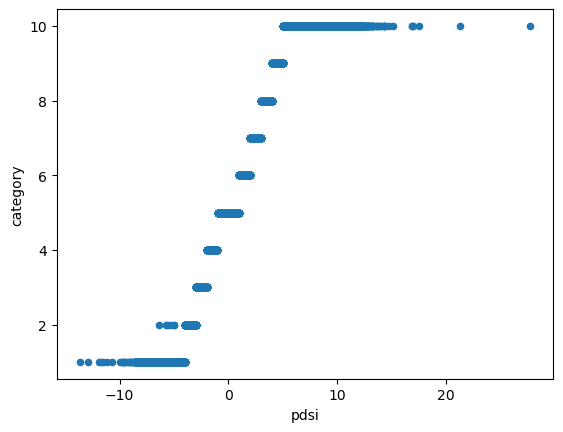

In [13]:
# sample 1347276 rows for plotting
features_plot = features.sample(1347276)
fig, ax = plt.subplots()
features_plot.plot.scatter(x='pdsi', y='category', ax=ax)
plt.show()

In [17]:
# check if air_temperature_x is always bigger than air_temperature_y
features[features['air_temperature_x'] < features['air_temperature_y']].shape
# WORTH TO NOTE

(3603, 16)

In [26]:
# rename relative_humidity_x as max_relative_humidity and relative_humidity_y as min_relative_humidity
features = features.rename(columns={'relative_humidity_x': 'max_relative_humidity', 'relative_humidity_y': 'min_relative_humidity'})
# rename air_temperature_x as max_air_temperature and air_temperature_y as min_air_temperature
features = features.rename(columns={'air_temperature_x': 'max_air_temperature', 'air_temperature_y': 'min_air_temperature'})

In [14]:
# rename category as "US Drought monitor classifications for standardized Palmer drought indices"
features.rename(columns={'category': 'pdsi_class'}, inplace=True)

In [15]:
# drop columns "wind_from_direction"
features.drop(columns=['wind_from_direction'], inplace=True)

In [16]:
features.shape

(134727600, 16)

In [27]:
# check missing values in features
features.isnull().sum()

lon                                                  0
lat                                                  0
day                                                  0
dead_fuel_moisture_1000hr                       882000
dead_fuel_moisture_100hr                        882000
pdsi                                            327600
pdsi_class                                     1209600
max_air_temperature                                  0
max_relative_humidity                           882000
max_wind_speed                                  945736
min_air_temperature                                  0
min_relative_humidity                           882002
precipitation_amount                         106721275
specific_humidity                               882000
surface_downwelling_shortwave_flux_in_air       882000
wind_speed                                      882000
dtype: int64

In [28]:
# check missing rate
features.isnull().sum() / features.shape[0]

lon                                          0.000000
lat                                          0.000000
day                                          0.000000
dead_fuel_moisture_1000hr                    0.006547
dead_fuel_moisture_100hr                     0.006547
pdsi                                         0.002432
pdsi_class                                   0.008978
max_air_temperature                          0.000000
max_relative_humidity                        0.006547
max_wind_speed                               0.007020
min_air_temperature                          0.000000
min_relative_humidity                        0.006547
precipitation_amount                         0.792126
specific_humidity                            0.006547
surface_downwelling_shortwave_flux_in_air    0.006547
wind_speed                                   0.006547
dtype: float64

In [29]:
# fill missing values in precipitation_amount using 0
features['precipitation_amount'].fillna(0, inplace=True)

C:\Users\fangshuye\AppData\Local\Temp\ipykernel_59292\2787728639.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  features['precipitation_amount'].fillna(0, inplace=True)


In [30]:
features.isnull().sum() / features.shape[0]

lon                                          0.000000
lat                                          0.000000
day                                          0.000000
dead_fuel_moisture_1000hr                    0.006547
dead_fuel_moisture_100hr                     0.006547
pdsi                                         0.002432
pdsi_class                                   0.008978
max_air_temperature                          0.000000
max_relative_humidity                        0.006547
max_wind_speed                               0.007020
min_air_temperature                          0.000000
min_relative_humidity                        0.006547
precipitation_amount                         0.000000
specific_humidity                            0.006547
surface_downwelling_shortwave_flux_in_air    0.006547
wind_speed                                   0.006547
dtype: float64

## Merge weather feature w other features and label

In [31]:
veg_data = pd.read_parquet('../Clean_Data/lon_lat_pair_weather_match_veg_v2.parquet')
slope_data = pd.read_parquet('../Clean_Data/lon_lat_pair_weather_match_slope.parquet')
road_density_data = pd.read_parquet('../Clean_Data/road_density_match_weather_grid.parquet')

In [32]:
veg_data.shape, slope_data.shape, road_density_data.shape

((17703, 7), (62160, 5), (17703, 3))

In [36]:
# only keep lon, lat, and fire_attribute
veg_data = veg_data[['lon', 'lat', 'fire_attribute']]
# only keep lon, lat, slope_avg and slope_max
slope_data = slope_data[['lon', 'lat', 'slope_avg', 'slope_max']]

In [37]:
# confirm there is no duplicated rows
veg_data.duplicated().sum(), slope_data.duplicated().sum(), road_density_data.duplicated().sum()

(0, 0, 0)

In [39]:
# merge the fire_label and features, inner join on the lon, lat, and day
mod_data = pd.merge(features, fire_label, on=['lon', 'lat', 'day'], how='inner')
mod_data.shape

(7264829, 17)

In [40]:
# left join the mod_data and veg_data on lon and lat
mod_data = pd.merge(mod_data, veg_data, on=['lon', 'lat'], how='left')
# left join the mod_data and slope_data on lon and lat
mod_data = pd.merge(mod_data, slope_data, on=['lon', 'lat'], how='left')
# left join the mod_data and road_density_data on lon and lat
mod_data = pd.merge(mod_data, road_density_data, on=['lon', 'lat'], how='left')
mod_data.shape

(7264829, 21)

In [43]:
mod_data.isnull().sum() / mod_data.shape[0]

lon                                          0.000000
lat                                          0.000000
day                                          0.000000
dead_fuel_moisture_1000hr                    0.007010
dead_fuel_moisture_100hr                     0.007010
pdsi                                         0.002527
pdsi_class                                   0.009536
max_air_temperature                          0.000000
max_relative_humidity                        0.007010
max_wind_speed                               0.007125
min_air_temperature                          0.000000
min_relative_humidity                        0.007010
precipitation_amount                         0.000000
specific_humidity                            0.007010
surface_downwelling_shortwave_flux_in_air    0.007010
wind_speed                                   0.007010
IS_FIRE                                      0.000000
fire_attribute                               0.000000
slope_avg                   

In [41]:
mod_data_OOT = pd.merge(features, fire_label_OOT, on=['lon', 'lat', 'day'], how='inner')
mod_data_OOT.shape

(5022540, 17)

In [42]:
mod_data_OOT = pd.merge(mod_data_OOT, veg_data, on=['lon', 'lat'], how='left')
mod_data_OOT = pd.merge(mod_data_OOT, slope_data, on=['lon', 'lat'], how='left')
mod_data_OOT = pd.merge(mod_data_OOT, road_density_data, on=['lon', 'lat'], how='left')
mod_data_OOT.shape

(5022540, 21)

In [44]:
mod_data_OOT.isnull().sum() / mod_data_OOT.shape[0]

lon                                          0.000000
lat                                          0.000000
day                                          0.000000
dead_fuel_moisture_1000hr                    0.007431
dead_fuel_moisture_100hr                     0.007431
pdsi                                         0.002478
pdsi_class                                   0.009909
max_air_temperature                          0.000000
max_relative_humidity                        0.007431
max_wind_speed                               0.007431
min_air_temperature                          0.000000
min_relative_humidity                        0.007431
precipitation_amount                         0.000000
specific_humidity                            0.007431
surface_downwelling_shortwave_flux_in_air    0.007431
wind_speed                                   0.007431
IS_FIRE                                      0.000000
fire_attribute                               0.000000
slope_avg                   

In [45]:
# drop lon, lat
mod_data = mod_data.drop(columns=['lon', 'lat'])
mod_data.to_parquet('../Clean_Data/Model_Data/2001_2020_Downsample/Features_w_Label_Downsampled.parquet')

In [46]:
mod_data_OOT = mod_data_OOT.drop(columns=['lon', 'lat'])
mod_data_OOT.to_parquet('../Clean_Data/Model_Data/2020/Features_w_Label_2020_OOT.parquet')